# Iniciando PySpark

### Realiza instalação do pyspark

In [96]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Abrindo a sessão spark

In [97]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.appName("Project_Spark") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()



### Imports

In [98]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import pandas as pd

# melhor visualização do dataframe
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# # Session builder
# spark = SparkSession.builder.appName('sparkdf').getOrCreate()

# Obtendo dataframe

### Importando csv

In [99]:
caminho_local = "sample_data"
nome_arq = "owid-covid-data.csv"

In [100]:
df = spark.read.format('csv').\
options(header='true', \
inferschema='true').\
load(f'{caminho_local}/{nome_arq}',header=True)

# Trabalhando com os dados

### Separando os valores referentes ao Brasil do restante do mundo

In [101]:
df_br = df.filter(f.col('iso_code') == 'BRA')
df_br.select('iso_code', 'continent', 'location', 'date', 'total_cases').show()

+--------+-------------+--------+-------------------+-----------+
|iso_code|    continent|location|               date|total_cases|
+--------+-------------+--------+-------------------+-----------+
|     BRA|South America|  Brazil|2020-02-26 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-27 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-28 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-29 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-01 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-02 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-03 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-04 00:00:00|        4.0|
|     BRA|South America|  Brazil|2020-03-05 00:00:00|        4.0|
|     BRA|South America|  Brazil|2020-03-06 00:00:00|       13.0|
|     BRA|South America|  Brazil|2020-03-07 00:00:00|       13.0|
|     BRA|South America|  Brazil|2020-03-08 00:00:00|       20.0|
|     BRA|

### Criando uma Temp view para a manipulação com SQL

In [102]:
df_br.createOrReplaceTempView('covid_BR')

### Separação do total de casos do Brasil por mês nos anos de 2020 e 2021

In [121]:
casos_br = spark.sql('''
SELECT
  distinct(concat(split(date, '-')[0],split(date, '-')[1])) AS ANO_MES,
  total_cases,
  iso_code
FROM
  covid_BR
WHERE
  date = last_day(date) AND year(date) < 2022
ORDER BY
  ANO_MES ASC
''')
casos_br.show()

+-------+-----------+--------+
|ANO_MES|total_cases|iso_code|
+-------+-----------+--------+
| 202002|        2.0|     BRA|
| 202003|     5717.0|     BRA|
| 202004|    87187.0|     BRA|
| 202005|   516137.0|     BRA|
| 202006|  1412669.0|     BRA|
| 202007|  2670451.0|     BRA|
| 202008|  3914829.0|     BRA|
| 202009|  4817365.0|     BRA|
| 202010|  5537763.0|     BRA|
| 202011|  6341965.0|     BRA|
| 202012|  7681032.0|     BRA|
| 202101|  9208521.0|     BRA|
| 202102|1.0558091E7|     BRA|
| 202103|1.2763392E7|     BRA|
| 202104|1.4675104E7|     BRA|
| 202105|1.6557888E7|     BRA|
| 202106|1.8570296E7|     BRA|
| 202107|1.9922146E7|     BRA|
| 202108|2.0785196E7|     BRA|
| 202109|2.1432362E7|     BRA|
+-------+-----------+--------+
only showing top 20 rows



### Separação do total de casos do mundo por mês nos anos de 2020 e 2021

In [122]:
casos_mundo = df.groupBy(f.date_format(f.last_day(f.col('date')), 'yyyyMM').alias('ANO_MES')) \
                .agg(sum("total_cases").alias('total_cases'))\
                .orderBy('ANO_MES')\
                .filter(f.substring('ANO_MES', 0, 4) != '2022')

casos_mundo.show()

+-------+---------------+
|ANO_MES|    total_cases|
+-------+---------------+
| 202001|       154281.0|
| 202002|      6673815.0|
| 202003|     3.927801E7|
| 202004|   2.76003419E8|
| 202005|   6.13819381E8|
| 202006|   1.02348402E9|
| 202007|  1.768805163E9|
| 202008|  2.739773306E9|
| 202009|  3.653421595E9|
| 202010|  5.048969357E9|
| 202011|   6.87231132E9|
| 202012|  9.610390616E9|
| 202101| 1.224514442E10|
| 202102|1.2845142722E10|
| 202103|1.5840536997E10|
| 202104|1.7709109709E10|
| 202105|2.1194508583E10|
| 202106|2.2265415617E10|
| 202107|  2.46311465E10|
| 202108|2.6974802578E10|
+-------+---------------+
only showing top 20 rows



### Conversão dos dataframes para pandas

In [123]:
casos_br = casos_br.toPandas()
casos_mundo = casos_mundo.toPandas()

### Normalização da coluna de casos em ambos os dataframes

In [131]:
normalizado_br = (casos_br['total_cases']-casos_br['total_cases'].min())/(casos_br['total_cases'].max()-casos_br['total_cases'].min())
casos_br['normalizado'] = normalizado_br

normalizado_mundo = (casos_mundo['total_cases']-casos_mundo['total_cases'].min())/(casos_mundo['total_cases'].max()-casos_mundo['total_cases'].min())
casos_mundo['normalizado'] = normalizado_mundo

### Gráfico apresentando a taxa de casos mensais em relação ao Brasil e ao mundo

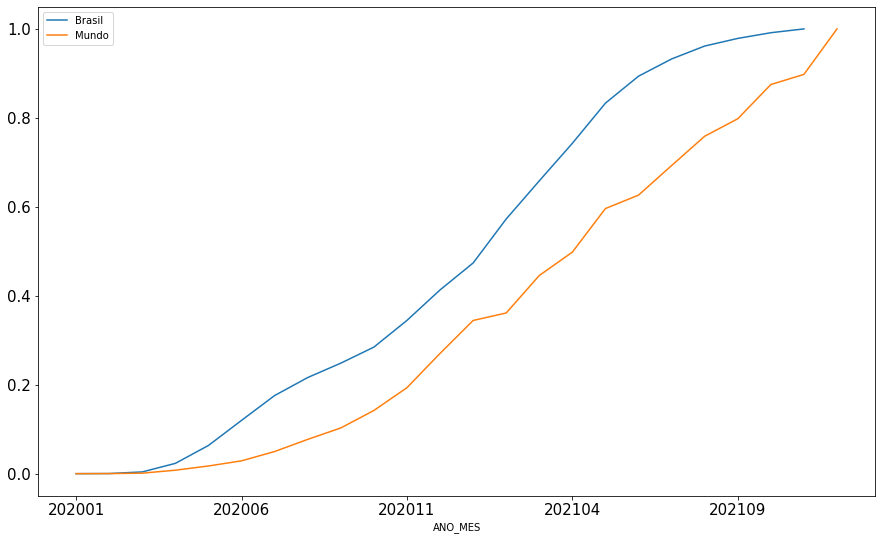

In [139]:
ax = casos_br.plot(x='ANO_MES', y='normalizado', label='Brasil')
casos_mundo.plot(ax=ax, x='ANO_MES', y='normalizado', label='Mundo', 
                 figsize=(15,9), fontsize = 15)

plt.show()